In [6]:
import torch
import torch.nn
from torch.distributions import Normal, Beta, Bernoulli, StudentT, MultivariateNormal, Uniform
from causal_cocycle.regression_functionals import NWFunctional
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor
from causal_cocycle.kernels_new import GaussianKernel, median_heuristic, median_heuristic_ard

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_multiple_conditional_cdfs(Y, weights, num_points=200, smooth=False, epsilon=0.0, labels=None):
    """
    Plots multiple conditional CDF estimates from weights.

    Parameters:
    - Y: tensor of shape (N,) or (N, 1)
    - weights: tensor of shape (N, K) where each column is a set of weights
    - num_points: number of points for y-grid
    - smooth: whether to apply smoothing (e.g., logistic)
    - epsilon: smoothing bandwidth (used if smooth=True)
    - labels: optional list of K labels for each CDF
    """
    Y = Y.flatten()  # (N,)
    N, K = weights.shape

    y_min, y_max = Y.min().item(), Y.max().item()
    y_grid = torch.linspace(y_min - 0.1, y_max + 0.1, num_points)

    cdf_matrix = torch.zeros(num_points, K)

    for j in range(K):  # over conditional CDFs
        w = weights[:, j].flatten()  # shape (N,)

        if smooth and epsilon > 0:
            cdf_vals = torch.stack([
                torch.sum(w * torch.sigmoid((y - Y) / epsilon)) for y in y_grid
            ])
        else:
            cdf_vals = torch.stack([
                torch.sum(w * (Y <= y).float()) for y in y_grid
            ])

        cdf_matrix[:, j] = cdf_vals

    # Plotting
    for j in range(K):
        label = labels[j] if labels and j < len(labels) else f"CDF {j+1}"
        plt.plot(y_grid.numpy(), cdf_matrix[:, j].numpy(), label=label)

    plt.xlabel("y")
    plt.ylabel("Estimated F_{Y|X}(y)")
    plt.title("Multiple Conditional CDF Estimates")
    plt.grid(True)
    plt.legend()
    plt.show()

### -----------------------------
### 1. NW Weights via .get_gram()
### -----------------------------

def compute_weights_from_kernel(kernel, Xtrain, x_query):
    """
    Returns normalized weights w_i(x_query) using kernel.get_gram()
    """
    K_vals = kernel.get_gram(x_query.unsqueeze(0), Xtrain).flatten()
    return K_vals / K_vals.sum()


### -----------------------------
### 2. Modified Build KR Transport using ε-smoothed CDFs
### -----------------------------

import torch

def build_modified_KR_transport(Y: torch.Tensor, w_src: torch.Tensor, w_tgt: torch.Tensor, epsilon: float):
    """
    Returns a function that implements the modified KR transport from P_{Y|x1} to P_{Y|x2}
    using ε-smoothed CDFs.
    
    Parameters:
      Y       : 1D torch.Tensor of sorted outcomes [Y₁,...,Yₙ].
      w_src   : 1D torch.Tensor of weights for the source distribution.
      w_tgt   : 1D torch.Tensor of weights for the target distribution.
      epsilon : float, the window half-width.
    
    Returns:
      A function KR(y) that maps a scalar (or tensor of scalars) y to the transported value.
    """
    # Define the window function S(z)
    def S(z):
        z = z.double()
        if epsilon == 0:
            # Return the indicator function: 0 if z < 0, 1 if z >= 0.
            return (z >= 0).float()
        else:
            return torch.where(z < -epsilon,
                               torch.zeros_like(z),
                               torch.where(z > epsilon,
                                           torch.ones_like(z),
                                           (z + epsilon) / (2 * epsilon)))
    
    # Source smoothed CDF:
    def F_src(y):
        # Ensure y is a torch.Tensor.
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, device=Y.device)
        # Ensure y has shape (batch, 1)
        if y.dim() == 0:
            y = y.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(1)
        Y_exp = Y.unsqueeze(0)  # shape (1, n)
        S_vals = S(y - Y_exp)   # shape (batch, n)
        return torch.sum(w_src * S_vals, dim=-1)  # shape (batch,)
    
    # Target quantile function (generalized pseudo-inverse):
    def Q_tgt(t):
        # Ensure t is a torch.Tensor.
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=Y.device)
        if t.dim() > 1:
            t = t.squeeze(-1)
        cumsum = torch.cumsum(w_tgt, dim=0)  # shape (n,)
        indices = torch.searchsorted(cumsum, t.unsqueeze(1)).squeeze(1)
        indices = torch.clamp(indices, 0, Y.numel()-1)
        j = indices - 1
        j_next = indices
        cumsum = torch.concatenate((torch.zeros(1), cumsum))
        cumsum_j = cumsum[j+1]  # shape (batch,)
        w_j_next = w_tgt[j_next]  # shape (batch,)
        s = (t - cumsum_j) / w_j_next  # in [0,1]
        Y_j_next = Y[j_next].double()
        return Y_j_next + epsilon * (2*s - 1)
        
    def KR(y):
        t_val = F_src(y)
        return Q_tgt(t_val)

    def KRinv(alpha):
        return F_src(Q_tgt(alpha))
    
    return KR, KRinv

### -----------------------------
### 4. Full Counterfactual Pipeline (A, B, C) using the modified KR transport
### -----------------------------

def full_counterfactual_pipeline(X, Y, kernel, epsilon: float = 0.0):
    """
    Constructs counterfactual outcomes under:
    A: Direct, B: Chain, C: Fork.
    
    If epsilon==0, the modified KR transport recovers the original (stepwise) KR transport.
    """
    device = X.device
    X = X.float()
    Y = Y.float().flatten()
    n = len(Y)
    
    # Define intervention values
    x_vals = {
        "00": torch.tensor([0.0, 0.0], device=device),
        "10": torch.tensor([1.0, 0.0], device=device),
        "11": torch.tensor([1.0, 1.0], device=device)
    }
    
    # Precompute fixed weights for intervention targets
    w_fixed = {k: compute_weights_from_kernel(kernel, X, x_vals[k]) for k in x_vals}
    w_i = [compute_weights_from_kernel(kernel, X, X[i]) for i in range(n)]

    # Strategy A: Direct KR maps from each X_i
    A = {
        key: torch.tensor([
            build_modified_KR_transport(Y, w_i[i], w_fixed[key], epsilon)(Y[i].item())
            for i in range(n)
        ])
        for key in ["00", "10", "11"]
    }
    
    # Strategy B: Sequential path: X_i → (0,0) → (1,0) → (1,1)
    B00 = torch.tensor([
        build_modified_KR_transport(Y, w_i[i], w_fixed["00"], epsilon)(Y[i].item())
        for i in range(n)
    ])
    B10 = torch.tensor([
        build_modified_KR_transport(Y, w_fixed["00"], w_fixed["10"], epsilon)(B00[i].item())
        for i in range(n)
    ])
    B11 = torch.tensor([
        build_modified_KR_transport(Y, w_fixed["10"], w_fixed["11"], epsilon)(B10[i].item())
        for i in range(n)
    ])
    B = {"00": B00, "10": B10, "11": B11}
    
    # Strategy C: Fork from (0,0)
    C00 = B00  # already computed
    C10 = torch.tensor([
        build_modified_KR_transport(Y, w_fixed["00"], w_fixed["10"], epsilon)(C00[i].item())
        for i in range(n)
    ])
    C11 = torch.tensor([
        build_modified_KR_transport(Y, w_fixed["00"], w_fixed["11"], epsilon)(C00[i].item())
        for i in range(n)
    ])
    C = {"00": C00, "10": C10, "11": C11}
    
    return A, B, C


### -----------------------------
### 5. Example usage
### -----------------------------
if __name__ == "__main__":
    # For demonstration, we create synthetic X, Y and a dummy kernel.

    kernel = GaussianKernel()
    
    # Synthetic data:
    n = 50
    X = torch.randn(n, 2).double()
    Y = torch.linspace(0, 1, steps=n).double()
    
    # Run the full counterfactual pipeline.
    # Set epsilon=0 to recover the original step function behavior.
    A, B, C = full_counterfactual_pipeline(X, Y, kernel, epsilon=1e-8)
    
    print("Strategy A outcomes:")
    for key in A:
        print(key, A[key])

TypeError: 'tuple' object is not callable

In [8]:
weights = torch.randn(100).abs()
weights = weights/weights.sum()


In [2]:
mu = torch.zeros(2)
corr = 0.999
cov = torch.eye(2)*(1-corr) + corr*torch.ones((2,2))

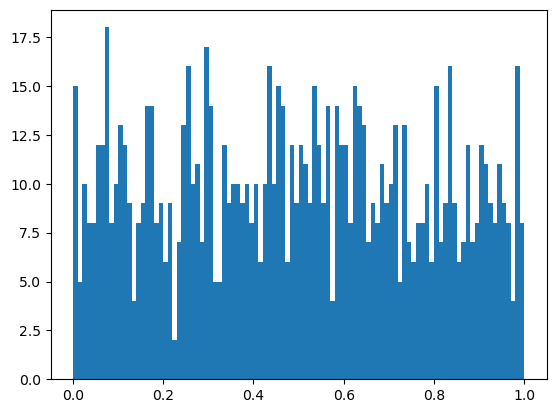

In [3]:
# Custom design
torch.manual_seed(0)
n = 1000
nint = 10**4
#X = torch.sigmoid(StudentT(4,0,1).sample((n,2))/2)
#X = torch.sigmoid(StudentT(5,0,1).sample((n,2))/2)
X = Uniform(0,1).sample((n,2))
Z = Uniform(0,1).sample((n,1)) @ torch.ones((1,2))
#X = torch.sigmoid(Normal(0,1).sample((n,2)))
#Z = torch.sigmoid(MultivariateNormal(mu,cov).sample((n,)))
B = Bernoulli(0.1).sample((n,1))
X = X*B + Z*(1-B)
#X = Beta(10,10).sample((n,2))

Y = X.sum(1) + Normal(0,1).sample((n,))
U =  Normal(0,1).sample((nint,))
Y11 = 2 + U
Y10 = 1 + U
Y00 = 0 + U
import matplotlib.pyplot as plt
plt.hist(X[:,1], bins = 100);

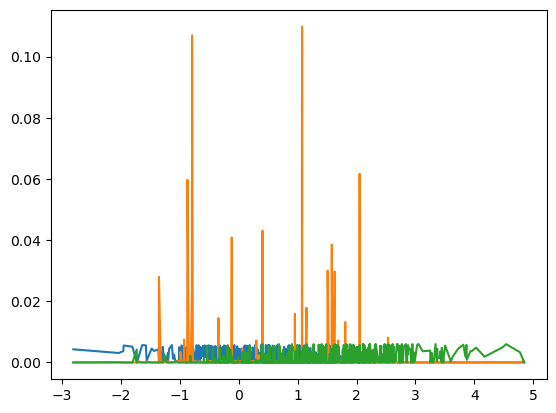

In [4]:
_min,_max = 0.00,1.0
Xtest = torch.tensor([[_min,_min],[_min,_max],[_max,_max]])
ls = median_heuristic_ard(X)
kernel = GaussianKernel(lengthscale = ls)
weights = kernel.get_gram(Xtest,X)
weights = weights.T/weights.sum(1)
sorted_Y, sort_idx = torch.sort(Y)
sorted_weights = weights[sort_idx]
sorted_X = X[sort_idx]
plt.plot(sorted_Y,sorted_weights.detach())

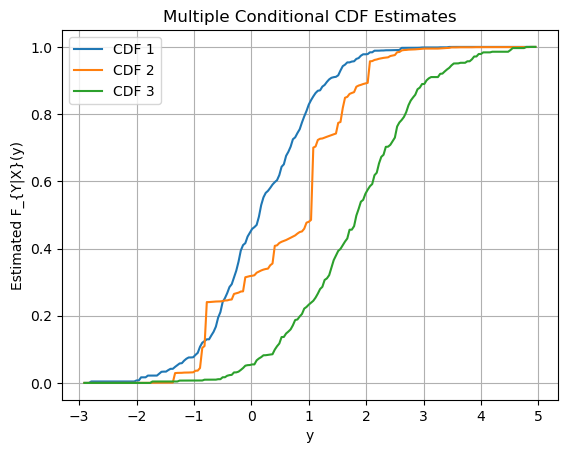

In [5]:
plot_multiple_conditional_cdfs(Y, weights.detach(), smooth=False, epsilon = 0.00)

In [6]:
((Y[:,None] - Y.T).abs() + torch.eye(n)).min()

/tmp/ipykernel_2956015/2255980937.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706712279749/work/aten/src/ATen/native/TensorShape.cpp:3614.)
  ((Y[:,None] - Y.T).abs() + torch.eye(n)).min()


tensor(2.8610e-06)

In [7]:
# Run counterfactual pipeline
A, B, C = full_counterfactual_pipeline(sorted_X, sorted_Y, kernel, epsilon = 1e-6)

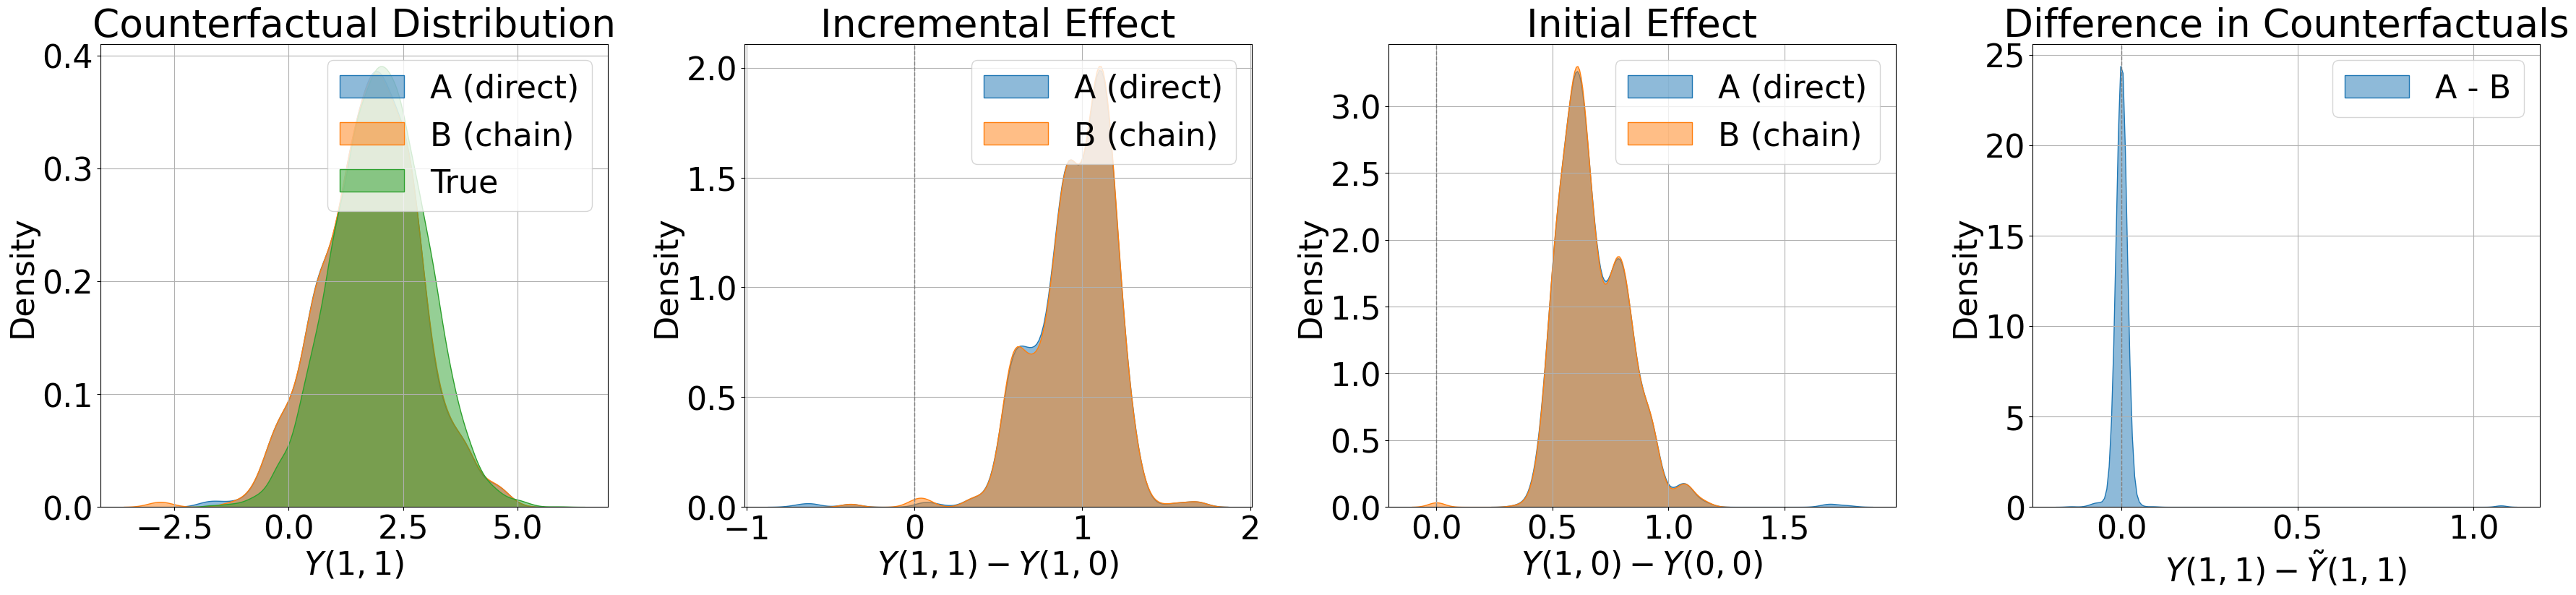

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute differences
diff_AB = (A["11"] - B["11"]).numpy()
diff_AC = (A["11"] - C["11"]).numpy()
diff_BC = (B["11"] - C["11"]).numpy()

# Set global font size
plt.rcParams.update({'font.size': 32})

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(36, 9))  # width x height in inches

## 1. Counterfactual Distribution at (1,1)
sns.kdeplot(A["11"], fill=True, alpha=0.5, label="A (direct)", ax=axes[0])
sns.kdeplot(B["11"], fill=True, alpha=0.5, label="B (chain)", ax=axes[0])
sns.kdeplot(Y11, fill=True, alpha=0.5, label="True", ax=axes[0])
axes[0].set_title("Counterfactual Distribution")
axes[0].set_xlabel(r"$Y(1,1)$")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

## 2. Incremental Effect: Y(1,1) - Y(1,0)
sns.kdeplot((A["11"] - A["10"]), fill=True, alpha=0.5, label="A (direct)", ax=axes[1])
sns.kdeplot((B["11"] - B["10"]), fill=True, alpha=0.5, label="B (chain)", ax=axes[1])
#sns.kdeplot(Y11 - Y10, fill=True, alpha=0.5, label="True", ax=axes[1])
axes[1].axvline(0.0, linestyle='--', color='gray', linewidth=1)
axes[1].set_title("Incremental Effect")
axes[1].set_xlabel(r"$Y(1,1) - Y(1,0)$")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True)

## 2. Incremental Effect: Y(1,0) - Y(0,0)
sns.kdeplot((A["10"] - A["00"]), fill=True, alpha=0.5, label="A (direct)", ax=axes[2])
sns.kdeplot((B["10"] - B["00"]), fill=True, alpha=0.5, label="B (chain)", ax=axes[2])
#sns.kdeplot(Y10 - Y00, fill=True, alpha=0.5, label="True", ax=axes[2])
axes[2].axvline(0.0, linestyle='--', color='gray', linewidth=1)
axes[2].set_title("Initial Effect")
axes[2].set_xlabel(r"$Y(1,0) - Y(0,0)$")
axes[2].set_ylabel("Density")
axes[2].legend()
axes[2].grid(True)

## 3. Differences Between Strategies
sns.kdeplot(diff_AB, fill=True, label="A - B", alpha=0.5, ax=axes[3])
#sns.kdeplot(diff_AC, fill=True, label="A - C", alpha=0.5, ax=axes[3])
#sns.kdeplot(diff_BC, fill=True, label="B - C", alpha=0.5, ax=axes[3])
axes[3].axvline(0.0, linestyle='--', color='gray', linewidth=1)
axes[3].set_title("Difference in Counterfactuals")
axes[3].set_xlabel(r"$Y(1,1) - \tilde Y(1,1)$")
axes[3].set_ylabel("Density")
axes[3].legend()
axes[3].grid(True)

# Tight layout and show
plt.tight_layout()
fig.savefig("ModKR_consistency.png", bbox_inches = "tight")
plt.show()

In [9]:
A["11"].numpy().mean(),B["11"].numpy().mean(), C["11"].numpy().mean()

(1.7845311, 1.7826976, 1.781301)

In [10]:
(A["11"]-A["10"]).numpy().mean(),(B["11"]-B["10"]).numpy().mean(), (C["11"]-C["10"]).numpy().mean()

(0.9487858, 0.9520253, 0.95062876)

In [11]:
(A["11"]-A["00"]).numpy().mean(),(B["11"]-B["00"]).numpy().mean(), (C["11"]-C["00"]).numpy().mean()

(1.6260638, 1.6242304, 1.6228337)

In [12]:
(A["10"]-A["00"]).numpy().mean(),(B["10"]-B["00"]).numpy().mean(), (C["10"]-C["00"]).numpy().mean()

(0.67727816, 0.67220503, 0.67220503)